In [2]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import csv

In [3]:
class AutoEncoder(torch.nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(18, 9),
            torch.nn.ReLU(),
            torch.nn.Linear(9, 6),
            torch.nn.ReLU(),
            torch.nn.Linear(6, 3),
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(3, 6),
            torch.nn.ReLU(),
            torch.nn.Linear(6, 9),
            torch.nn.ReLU(),
            torch.nn.Linear(9, 18),
            torch.nn.ReLU(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [4]:
with open('../background_data.txt', 'r') as f:
    data = f.read()
parsed_data = []
lines = data.split('\n')
print(len(lines))
total_padded = 0
i = 0
while i < len(lines):
    if i%10000 ==0:
        print("working: {}".format(i))
    line = lines[i].strip()
    i += 1  # Increment i here to ensure it always moves to the next line

    if line:
        if line.isdigit():  # Check if the line contains only digits (number of jets)
            num_jets = int(line)
            jets_data = []

            for _ in range(num_jets):
                if i < len(lines):
                    jet_values = [float(val) for val in lines[i].split()]
                    jets_data.extend(jet_values)
                    i += 1  # Increment i for each jet line

            # Padding if fewer than 6 jets
            while len(jets_data) < 6 * 3:
                jets_data.append(0.0)
                total_padded += 1

            # Truncate if more than 6 jets (optional, based on your requirement)
            jets_data = jets_data[:18]
            parsed_data.append(jets_data)

# Display the parsed data
print(len(parsed_data))


# Path for the new CSV file
output_file_path = 'DELETE.csv'

# Writing the parsed data to a CSV file
with open(output_file_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(parsed_data)

print(total_padded)

4294602
working: 0
working: 60000
working: 200000
working: 210000
working: 250000
working: 410000
working: 420000
working: 900000
working: 920000
working: 1160000
working: 1230000
working: 1410000
working: 1420000
working: 1540000
working: 1710000
working: 1770000
working: 2100000
working: 2220000
working: 2540000
working: 2840000
working: 3230000
working: 3330000
working: 3380000
working: 3710000
working: 3900000
working: 3940000
working: 4070000
working: 4100000
working: 4190000
working: 4220000
350181
6705


In [5]:
file_path = 'parsed_data.csv'  # Replace with your CSV file path

line_count = 0
with open(file_path, 'r') as file:
    for line in file:
        line_count += 1

print(f"Number of lines in the CSV file: {line_count}")


FileNotFoundError: [Errno 2] No such file or directory: 'parsed_data.csv'

In [7]:
print(torch.cuda.is_available())

False


In [6]:
csv_file_path = '../parsed_data.csv'
parsed_data = []
parsed_signal_data = []
with open(csv_file_path, 'r') as csvfile:
    csv_reader = csv.reader(csvfile)
    
    for row in csv_reader:
        data_point = [float(value) for value in row]
        parsed_data.append(data_point)

print(len(parsed_data))

with open("../parsed_signal_data.csv", 'r') as csvfile:
    csv_reader = csv.reader(csvfile)
    
    for row in csv_reader:
        data_point = [float(value) for value in row]
        parsed_signal_data.append(data_point)

print(len(parsed_signal_data))

350181
53000


In [14]:
from sklearn.model_selection import train_test_split

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU is available')
else:
    device = torch.device('cpu')
    print('GPU not available, CPU used')

tensor_data = torch.tensor(parsed_data, dtype=torch.float)
train_data, val_data = train_test_split(tensor_data, test_size=0.2, random_state=42)
train_dataset = TensorDataset(train_data)
val_dataset = TensorDataset(val_data)
batch_size = 1024  # adjust later
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
model = AutoEncoder()
model.to(device)
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 


GPU is available


In [16]:
num_epochs = 20  # Number of training epochs
for epoch in range(num_epochs):
    # Training Phase
    model.train()  # Set the model to training mode
    train_loss = 0.0
    for data in train_dataloader:
        inputs = data[0].to(device)  # Assuming data is a tuple of (input, target)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    # Calculate average training loss
    train_loss /= len(train_dataloader.dataset)

    # Validation Phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # Turn off gradients for validation
        for data in val_dataloader:
            inputs = data[0].to(device)  # Assuming data is a tuple of (input, target)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, inputs)

            val_loss += loss.item() * inputs.size(0)

    # Calculate average validation loss
    val_loss /= len(val_dataloader.dataset)

    # Print epoch summary
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')


Epoch 1/20, Training Loss: 2450.9058, Validation Loss: 2166.7591
Epoch 2/20, Training Loss: 2149.8009, Validation Loss: 2157.2379
Epoch 3/20, Training Loss: 2132.9645, Validation Loss: 2119.9982
Epoch 4/20, Training Loss: 1840.0275, Validation Loss: 1055.1729
Epoch 5/20, Training Loss: 988.4210, Validation Loss: 957.6894
Epoch 6/20, Training Loss: 902.1785, Validation Loss: 894.1413
Epoch 7/20, Training Loss: 889.9994, Validation Loss: 893.3907
Epoch 8/20, Training Loss: 889.3732, Validation Loss: 892.9784
Epoch 9/20, Training Loss: 889.1023, Validation Loss: 892.3953
Epoch 10/20, Training Loss: 888.9682, Validation Loss: 892.4054
Epoch 11/20, Training Loss: 888.9301, Validation Loss: 892.4731
Epoch 12/20, Training Loss: 888.8929, Validation Loss: 892.1134
Epoch 13/20, Training Loss: 888.7906, Validation Loss: 892.2294
Epoch 14/20, Training Loss: 888.8641, Validation Loss: 892.4237
Epoch 15/20, Training Loss: 888.7865, Validation Loss: 892.2262
Epoch 16/20, Training Loss: 888.7713, Val

In [9]:
model_save_path = "../model/autoencoder_model.pth"
torch.save(model.state_dict(), model_save_path)

In [10]:
model = AutoEncoder()
model.load_state_dict(torch.load(model_save_path))
model.eval()

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=18, out_features=9, bias=True)
    (1): ReLU()
    (2): Linear(in_features=9, out_features=6, bias=True)
    (3): ReLU()
    (4): Linear(in_features=6, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=9, bias=True)
    (3): ReLU()
    (4): Linear(in_features=9, out_features=18, bias=True)
    (5): ReLU()
  )
)

## Model Evaluation through Background Reconstruction Error & Signal Reconstruction Error

Iteration 1

In [11]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU is available')
else:
    device = torch.device('cpu')
    print('GPU not available, CPU used')

background_tensor_data = torch.tensor(parsed_data, dtype=torch.float)
background_dataset = TensorDataset(background_tensor_data)
background_dataloader = DataLoader(background_dataset, batch_size=1024, shuffle=False)

background_reconstruction_loss = []
model = AutoEncoder()  # Replace with your actual model class name
model.load_state_dict(torch.load('../model/autoencoder_model.pth', map_location=device))
model.to(device)
model.eval()
with torch.no_grad():
    for data in background_dataloader:
        inputs = data[0].to(device)
        reconstructed = model(inputs)
        error = torch.sum((inputs-reconstructed)**2, dim=1)
        background_reconstruction_loss.extend(error.cpu().numpy())

GPU not available, CPU used


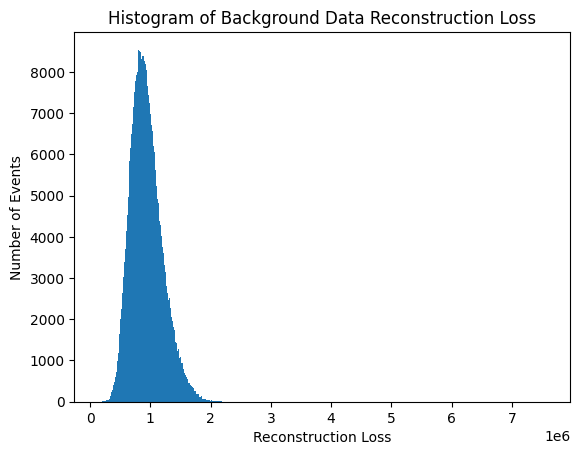

In [12]:
plt.hist(background_reconstruction_loss, bins=500)
plt.xlabel('Reconstruction Loss')
plt.ylabel('Number of Events')
plt.title("Histogram of Background Data Reconstruction Loss")
plt.show()

In [13]:
max_error = max(background_reconstruction_loss)
min_error = min(background_reconstruction_loss)
print(max_error)
print(min_error)

7597196.5
113627.98


In [14]:
sum = 0
for i in background_reconstruction_loss:
    sum += i

print(sum/len(background_reconstruction_loss))

937605.5829749695


#### Signal Reconstruction Error

In [15]:
signal_tensor_data = torch.tensor(parsed_signal_data, dtype=torch.float)
signal_dataset = TensorDataset(signal_tensor_data)
signal_dataloader = DataLoader(signal_dataset, batch_size=1024, shuffle=False)

signal_reconstruction_loss = []
with torch.no_grad():
    for data in signal_dataloader:
        inputs = data[0].to(device)
        reconstructed = model(inputs)
        error = torch.sum((inputs-reconstructed)**2, dim=1)
        signal_reconstruction_loss.extend(error.cpu().numpy())

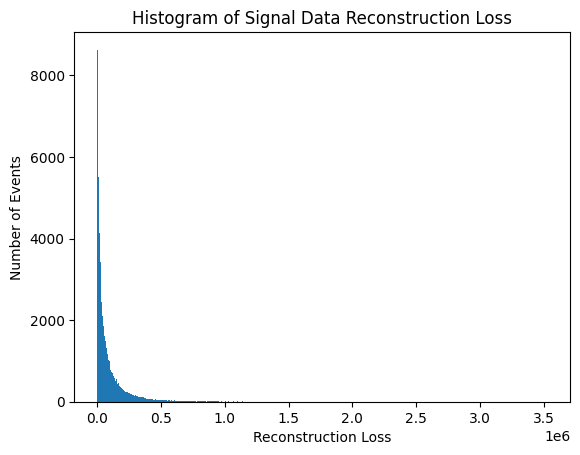

In [16]:
plt.hist(signal_reconstruction_loss, bins=500)
plt.xlabel('Reconstruction Loss')
plt.ylabel('Number of Events')
plt.title("Histogram of Signal Data Reconstruction Loss")
plt.show()

In [17]:
max_error = max(signal_reconstruction_loss)
min_error = min(signal_reconstruction_loss)
print(max_error)
print(min_error)

3530099.2
0.2697748


In [18]:
sum = 0
for i in signal_reconstruction_loss:
    sum += i

print(sum/len(signal_reconstruction_loss))

93640.03507117154


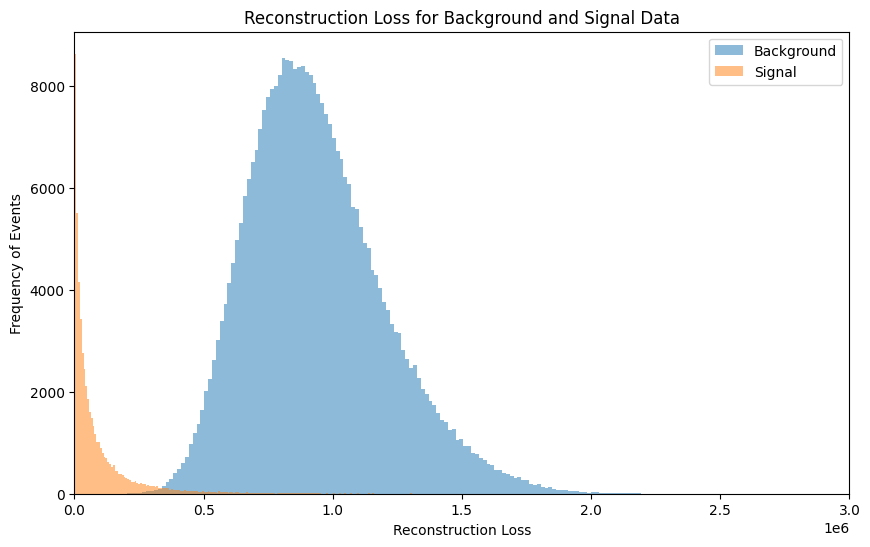

In [26]:
plt.figure(figsize=(10,6))

plt.hist(background_reconstruction_loss, bins=500, alpha=0.5, label='Background')
plt.hist(signal_reconstruction_loss, bins=500, alpha=0.5, label='Signal')   

plt.title("Reconstruction Loss for Background and Signal Data")
plt.xlabel("Reconstruction Loss")
plt.ylabel("Frequency of Events")
plt.legend(loc='upper right')

plt.xlim(0, 3000000)
plt.show()

## Signal Dataset Evaluation

In [5]:
with open('../signal_data.txt', 'r') as f:
    data = f.read()
parsed_signal_data = []
lines = data.split('\n')
print(len(lines))
jet_padded = 0
i = 0
while i < len(lines):
    if i%10000 ==0:
        print("working: {}".format(i))
    line = lines[i].strip()
    i += 1  # Increment i here to ensure it always moves to the next line

    if line:
        if line.isdigit():  # Check if the line contains only digits (number of jets)
            num_jets = int(line)
            jets_data = []

            for _ in range(num_jets):
                if i < len(lines):
                    jet_values = [float(val) for val in lines[i].split()]
                    jets_data.extend(jet_values)
                    i += 1  # Increment i for each jet line

            # Padding if fewer than 6 jets
            while len(jets_data) < 6 * 3:
                jets_data.append(0.0)
                jet_padded += 1

            # Truncate if more than 6 jets (optional, based on your requirement)
            jets_data = jets_data[:18]
            parsed_signal_data.append(jets_data)

# Display the parsed data
print(len(parsed_signal_data))


# Path for the new CSV file
output_file_path = 'DELETE2.csv'

# Writing the parsed data to a CSV file
with open(output_file_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(parsed_signal_data)

print(jet_padded)

404071
working: 0
working: 120000
working: 150000
working: 180000
working: 210000
53000
133170


In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU is available')
else:
    device = torch.device('cpu')
    print('GPU not available, CPU used')

tensor_data = torch.tensor(parsed_signal_data, dtype=torch.float)
signal_dataset = TensorDataset(tensor_data)
signal_dataloader = DataLoader(signal_dataset, batch_size=1024, shuffle=False)

model = AutoEncoder()  # Replace with your actual model class name
model.load_state_dict(torch.load('../mode/autoencoder_model.pth', map_location=device))
model.to(device)
model.eval()

